In [1]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [2]:
!ls "/content/gdrive/My Drive/3D_cnn_classfication"

 3D_CNN_CLASSFICATION.ipynb	        High_nii_format   Untitled0.ipynb
'Copie de 3D_CNN_CLASSFICATION.ipynb'   Low		  wavelet_3D_CNN_CLASSFICATION.ipynb
 High				        Low_nii_format


In [3]:
pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.9 MB/s eta 0:00:00


In [4]:
import os
import glob
import random
import tempfile

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
#import wandb
from ipywidgets import IntSlider, interact
#from kaggle_secrets import UserSecretsClient
from matplotlib import animation, rc
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
from scipy import ndimage
from scipy.ndimage import zoom
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
from sklearn.utils import class_weight
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (BatchNormalization, Conv3D, Dense,
                                     Dropout, GlobalAveragePooling3D,
                                     Input, MaxPool3D, Rescaling)
from tensorflow.keras.optimizers import Adam
#from wandb.keras import WandbCallback

In [5]:
import SimpleITK as sitk

In [6]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Preprocessing image func


In [7]:
def read_volume(filepath):
    """Read and load volume"""
    # Read file
    #scan = nib.load(filepath)
    scan = sitk.ReadImage(filepath)
    # Get raw data
    #scan = scan.get_fdata()
    scan = sitk.GetArrayFromImage(scan)
    return scan
def normalize(volume):
    """Normalize the volume"""
    volume_mean = np.mean(volume)
    volume_std = np.std(volume)
    volume = (volume - volume_mean) / volume_std
    volume = volume.astype("float32")
    return volume
def resize_volume(img,filepath):
    """Resize across z-axis"""
    scan = sitk.ReadImage(filepath)
    # Set the desired depth
    desired_depth = 32
    desired_width = 256
    desired_height = 256
    # Get current depth
    current_depth = scan.GetDepth()
    current_width = scan.GetWidth()
    current_height = scan.GetHeight()
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 0, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (depth_factor, height_factor,width_factor ), order=1)
    return img
import pywt
def wavelet_approximation(volume):

    wavename = 'haar'
    coeffs = pywt.dwtn(volume, wavename)
    appro = coeffs['aaa']
    appro_volume = appro.astype("float32")
    return appro_volume
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_volume(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume,path)
    #wavelet decomposition
    volume = wavelet_approximation(volume)
    return volume

Load data

In [8]:
# Folder "low" consist of MRI scans having Low lever cancer,
Low_scan_paths = [
    os.path.join(os.getcwd(), '/content/gdrive/My Drive/3D_cnn_classfication/Low_nii_format', x)
    for x in os.listdir('/content/gdrive/My Drive/3D_cnn_classfication/Low_nii_format')
]
# Folder "High" consist of CT scans having High lever cancer,
High_scan_paths = [
    os.path.join(os.getcwd(), '/content/gdrive/My Drive/3D_cnn_classfication/High_nii_format', x)
    for x in os.listdir('/content/gdrive/My Drive/3D_cnn_classfication/High_nii_format')
]
print("MRI scans with LOW cancer: " + str(len(Low_scan_paths)))
print("MRI scans with HIGH cancer: " + str(len(High_scan_paths)))
# Labels
Low_scans = np.array([process_scan(path) for path in Low_scan_paths])
Low_labels = np.array([0 for _ in range(len(Low_scans))])
print(Low_labels)

High_scans = np.array([process_scan(path) for path in High_scan_paths])
High_labels = np.array([1 for _ in range(len(High_scans))])
print(High_labels)

MRI scans with LOW cancer: 210
MRI scans with HIGH cancer: 85
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [9]:
#scans
abnormal_scans = High_scans
normal_scans = Low_scans
scans = np.concatenate((normal_scans, abnormal_scans), axis=0)
#labels
abnormal_labels = High_labels
normal_labels = Low_labels
labels = np.concatenate((Low_labels, High_labels), axis=0)
paths = np.concatenate((Low_labels, High_labels), axis=0)
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


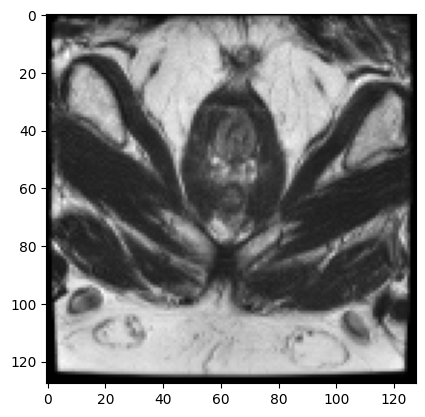

In [10]:
# show image
import matplotlib.pyplot as plt
image = abnormal_scans[18,:,:,:]
plt.imshow(np.squeeze(image[15, :, :]),cmap="gray")

In [11]:
abnormal_scans.shape

(85, 16, 128, 128)

dataset distribution
Model generation

In [12]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20,-15, -10, -5, 5, 10,15, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        #volume[volume < 0] = 0
        #volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    #volume = add_gaussian_noise(volume,0.0, 0.1)
    #volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [13]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
def get_model(depth=16, height=128, width=128):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth,height,width, 1))

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.3)(x)

    #x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.3)(x)

    #x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)



    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model( depth=16,  height=128,width=128)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 128, 128, 1   0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 14, 126, 126, 16   448       
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 63, 63, 16)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 7, 63, 63, 16)     64        
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 61, 61, 32)     13856 

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

shape validation data: (10, 16, 128, 128)
validation data indice: [221, 285, 35, 214, 279, 26, 264, 188, 57, 62]
validation data labels: [1 1 0 1 1 0 1 0 0 0]
Remaining_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 19

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 1s 13ms/step - loss: 0.6922 - acc: 0.5143 - val_loss: 0.7016 - val_acc: 0.5000
Epoch 3/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6903 - acc: 0.5486 - val_loss: 0.6911 - val_acc: 0.5000
Epoch 4/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6908 - acc: 0.5371 - val_loss: 0.6839 - val_acc: 0.5000
Epoch 5/100
88/88 [==============================] - 1s 12ms/step - loss: 0.6921 - acc: 0.5029 - val_loss: 0.6867 - val_acc: 0.5000
Epoch 6/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6886 - acc: 0.5429 - val_loss: 0.6818 - val_acc: 0.5000
Epoch 7/100
88/88 [==============================] - 1s 15ms/step - loss: 0.6841 - acc: 0.5543 - val_loss: 0.6744 - val_acc: 0.5000
Epoch 8/100
88/88 [==============================] - 1s 14ms/step - loss: 0.6855 - acc: 0.5486 - val_loss: 0.6699 - val_acc: 0.5000
Epoch 9/100
88/88 [==============================] - 1s 12ms/step - loss: 0.6860 - acc: 

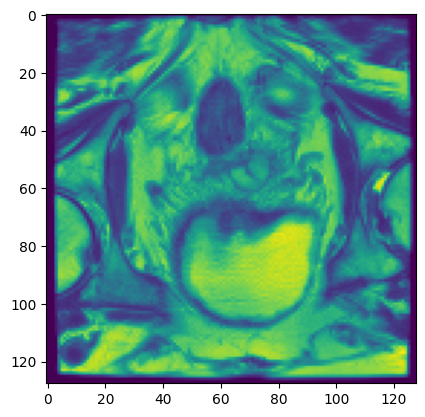

In [14]:
# labels
labels = np.concatenate((Low_labels, High_labels), axis=0)
paths = np.concatenate((Low_labels, High_labels), axis=0)
# data
scans = np.concatenate((normal_scans, abnormal_scans), axis=0)


#validation dataset 20% of all data
selected_zeros_indices = random.sample(range(Low_labels.shape[0]), 5)
selected_ones_indices = random.sample(range(Low_labels.shape[0], Low_labels.shape[0]+High_labels.shape[0]), 5)
selected_indices = selected_zeros_indices + selected_ones_indices
random.shuffle(selected_indices)
x_val = scans[selected_indices]
y_val = labels[selected_indices]

print('shape validation data:',x_val.shape)
print('validation data indice:',selected_indices)
print('validation data labels:',y_val)

# remaining indices
remaining_indices = [i for i in range(295) if i not in selected_indices]
print('Remaining_indices:', remaining_indices)
prediction_ensemble= []
for i in range (0,1,1):
    #trainning_datase
    x_train = np.ndarray(shape=(175,16,128,128))
    y_train = np.ndarray(shape=(175,))
    High_scans_training_indices = remaining_indices[205:205+80]
    print('High scans training indices:',High_scans_training_indices)
    low_scans_training_indices = random.sample(range(205), 95)
    low_scans_training_indices = [remaining_indices[i] for i in low_scans_training_indices]
    print('Low scans training indices',low_scans_training_indices)
    training_selected_indices = High_scans_training_indices+low_scans_training_indices
    random.shuffle(training_selected_indices)
    print('training indices:',training_selected_indices)
    x_train = scans[training_selected_indices]
    y_train = labels[training_selected_indices]
    print('Trainning data shape:',x_train.shape)
    print('Traning data labels:',y_train)

    # Define data loaders.
    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    batch_size = 2
    # Augment the on the fly during training.
    train_dataset = (
          train_loader.shuffle(len(x_train))
          .map(train_preprocessing)
          .batch(batch_size)
          .prefetch(2))
    # Only rescale.
    validation_dataset = (
          validation_loader.shuffle(len(x_val))
          .map(validation_preprocessing)
          .batch(batch_size)
          .prefetch(2))
    #show image
    import matplotlib.pyplot as plt

    data = train_dataset.take(1)
    images, image_labels = list(data)[0]
    images = images.numpy()
    image = images[0]
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(np.squeeze(image[4, :, ])) #cmap="gray")

    # Visualize montage of slices.
    # 4 rows and 10 columns for 100 slices of the CT scan.
    #plot_slices(3, 5, 128, 128, image[:, :, :15])

    # model
    # Compile model.
    initial_learning_rate = 0.0001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
            )

    model = get_model(depth=16, height=128, width=128)
    model.compile(
            loss="binary_crossentropy",
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=["acc"],
                  )
# Define callbacks.
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
            "wavelet_haar_3d_cnn_version1.h5", save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
    epochs = 100
    model.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=epochs,
            batch_size = 32,
            shuffle=True,
            verbose=1,
            callbacks=[checkpoint_cb, early_stopping_cb])
            #model prediction
    preds = model.predict(validation_dataset,verbose=1)
    predictions0 = preds.copy()

    #prediction_ensemble.append(predictions0)

In [15]:

model.load_weights("wavelet_haar_3d_cnn_version1.h5")
y_pred = np.ndarray(shape=(10,))
for num in range(0,10,1):

  prediction = model.predict(np.expand_dims(x_val[num], axis=0))[0]
  y_pred[num] = prediction
  print(y_pred[num])
  scores = [1 - prediction[0], prediction[0]]
  print(scores)
  class_names = ["Low", "High"]
  print('real class:', y_val[num])
  for score, name in zip(scores, class_names):
      print(
         "This model is %.2f percent confident that cancer is %s"
         % ((100 * score), name)
          )

1/1 [==============================] - 0s 91ms/step
0.826915442943573
[0.173084557056427, 0.82691544]
real class: 1
This model is 17.31 percent confident that cancer is Low
This model is 82.69 percent confident that cancer is High
1/1 [==============================] - 0s 17ms/step
0.8317466378211975
[0.1682533621788025, 0.83174664]
real class: 1
This model is 16.83 percent confident that cancer is Low
This model is 83.17 percent confident that cancer is High
1/1 [==============================] - 0s 17ms/step
0.5430364608764648
[0.45696353912353516, 0.54303646]
real class: 0
This model is 45.70 percent confident that cancer is Low
This model is 54.30 percent confident that cancer is High
1/1 [==============================] - 0s 17ms/step
0.4324982464313507
[0.5675017535686493, 0.43249825]
real class: 1
This model is 56.75 percent confident that cancer is Low
This model is 43.25 percent confident that cancer is High
1/1 [==============================] - 0s 18ms/step
0.550374031066894

In [16]:
print(y_pred)
print(y_val)

[0.82691544 0.83174664 0.54303646 0.43249825 0.55037403 0.15641578
 0.37689793 0.70187068 0.40807164 0.43477347]
[1 1 0 1 1 0 1 0 0 0]


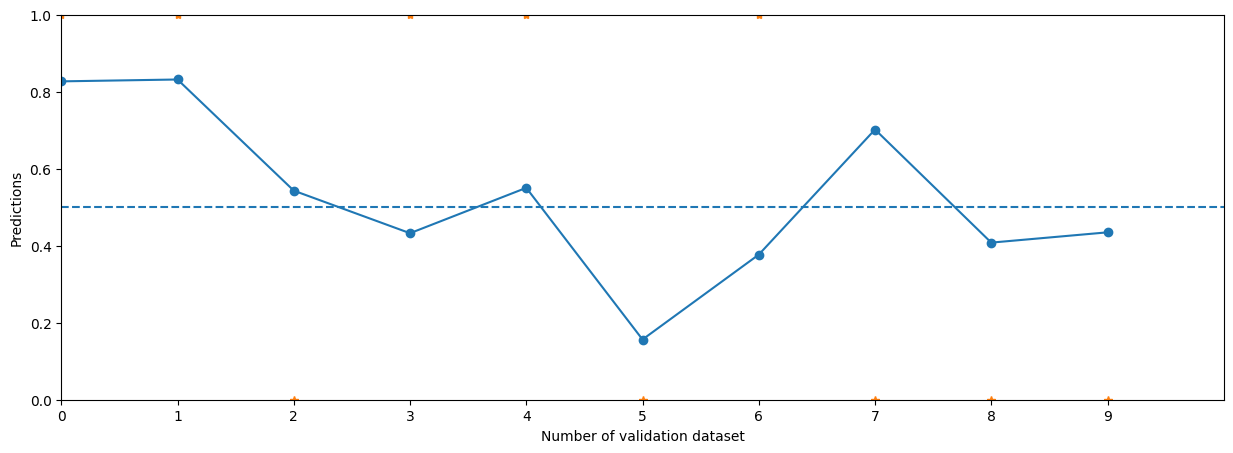

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
for i in range(0,1,1):

  plt.plot(y_pred,'o-')
  plt.plot(y_val,'*')
  plt.axhline(y = 0.5, linestyle = '--')

  plt.xlim([0,10])
  plt.xticks(range(10))
  plt.ylim(0,1)
  plt.ylabel('Predictions')
  plt.xlabel('Number of validation dataset')
  training_legend= "training_{:01d}".format(i)
  #plt.legend(loc='upper left', title=training_legend, fontsize=10)
  #plt.legend['training dataset 0','training dataset 1','training dataset 2','training dataset 3']

In [18]:
y_pred = y_pred.copy()
y_pred[y_pred<0.5] = 0
y_pred[y_pred>0.5] = 1

In [19]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_val, y_pred)
print(cnf_matrix)
tn, fp, fn ,tp = confusion_matrix(y_val,y_pred).reshape(-1)
print('Valeurs de TN, FP, FN, TP : \n',tn, fp, fn, tp)
from sklearn.metrics import classification_report
matrix = classification_report(y_val,y_pred)
print('Rapport de Classification  : \n',matrix)


[[3 2]
 [2 3]]
Valeurs de TN, FP, FN, TP : 
 3 2 2 3
Rapport de Classification  : 
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10



Version 2


High scans training indices: [210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 286, 287, 288, 289, 290, 291, 292, 293, 294]
Low scans training indices [120, 77, 112, 182, 192, 146, 173, 187, 128, 41, 50, 79, 58, 14, 152, 193, 142, 15, 84, 196, 12, 153, 126, 132, 139, 42, 190, 134, 20, 49, 17, 156, 178, 64, 107, 31, 149, 67, 195, 177, 10, 162, 180, 111, 202, 148, 137, 191, 70, 54, 161, 65, 71, 105, 34, 80, 121, 158, 18, 2, 170, 25, 150, 141, 56, 133, 169, 154, 93, 176, 66, 98, 76, 183, 116, 81, 172, 164, 123, 88, 13, 124, 181, 184, 145, 206, 117, 201, 99, 74, 19, 36, 38, 143, 27]
training indices: [121, 269, 270, 170, 288, 84, 56, 191, 182, 211, 229, 274, 196, 176, 19, 154, 76, 280, 227

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 1s 13ms/step - loss: 0.6915 - acc: 0.4914 - val_loss: 0.6889 - val_acc: 0.6000
Epoch 3/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6840 - acc: 0.5886 - val_loss: 0.6583 - val_acc: 0.7000
Epoch 4/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6855 - acc: 0.5429 - val_loss: 0.6356 - val_acc: 0.7000
Epoch 5/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6781 - acc: 0.5657 - val_loss: 0.6139 - val_acc: 0.7000
Epoch 6/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6797 - acc: 0.5829 - val_loss: 0.6014 - val_acc: 0.7000
Epoch 7/100
88/88 [==============================] - 1s 14ms/step - loss: 0.6859 - acc: 0.5371 - val_loss: 0.6017 - val_acc: 0.7000
Epoch 8/100
88/88 [==============================] - 1s 15ms/step - loss: 0.6843 - acc: 0.5886 - val_loss: 0.5893 - val_acc: 0.7000
Epoch 9/100
88/88 [==============================] - 1s 15ms/step - loss: 0.6840 - acc: 

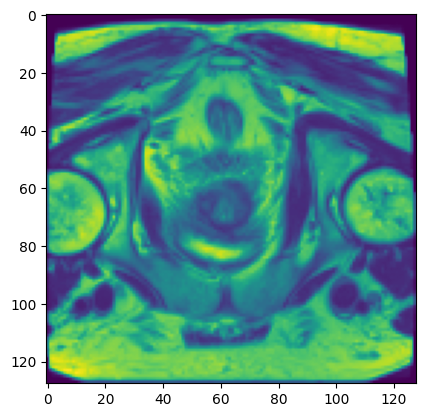

In [20]:
for i in range (0,1,1):
    #trainning_datase
    x_train = np.ndarray(shape=(175,16,128,128))
    y_train = np.ndarray(shape=(175,))
    High_scans_training_indices = remaining_indices[205:205+80]
    print('High scans training indices:',High_scans_training_indices)
    low_scans_training_indices = random.sample(range(205), 95)
    low_scans_training_indices = [remaining_indices[i] for i in low_scans_training_indices]
    print('Low scans training indices',low_scans_training_indices)
    training_selected_indices = High_scans_training_indices+low_scans_training_indices
    random.shuffle(training_selected_indices)
    print('training indices:',training_selected_indices)
    x_train = scans[training_selected_indices]
    y_train = labels[training_selected_indices]
    print('Trainning data shape:',x_train.shape)
    print('Traning data labels:',y_train)

    # Define data loaders.
    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    batch_size = 2
    # Augment the on the fly during training.
    train_dataset = (
          train_loader.shuffle(len(x_train))
          .map(train_preprocessing)
          .batch(batch_size)
          .prefetch(2))
    # Only rescale.
    validation_dataset = (
          validation_loader.shuffle(len(x_val))
          .map(validation_preprocessing)
          .batch(batch_size)
          .prefetch(2))
    #show image
    import matplotlib.pyplot as plt

    data = train_dataset.take(1)
    images, image_labels = list(data)[0]
    images = images.numpy()
    image = images[0]
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(np.squeeze(image[4, :, ])) #cmap="gray")

    # Visualize montage of slices.
    # 4 rows and 10 columns for 100 slices of the CT scan.
    #plot_slices(3, 5, 128, 128, image[:, :, :15])

    # model
    # Compile model.
    initial_learning_rate = 0.0001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
            )

    model2 = get_model(depth=16, height=128, width=128)
    model2.compile(
            loss="binary_crossentropy",
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=["acc"],
                  )
# Define callbacks.
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
            "wavelet_haar_3d_cnn_version2.h5", save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
    epochs = 100
    model2.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=epochs,
            batch_size = 32,
            shuffle=True,
            verbose=1,
            callbacks=[checkpoint_cb, early_stopping_cb])
            #model prediction
    preds2 = model2.predict(validation_dataset,verbose=1)
    predictions2 = preds2.copy()

In [21]:
model2.load_weights("wavelet_haar_3d_cnn_version2.h5")
y_pred2 = np.ndarray(shape=(10,))
for num in range(0,10,1):

  prediction = model2.predict(np.expand_dims(x_val[num], axis=0))[0]
  y_pred2[num] = prediction
  print(y_pred2[num])
  scores = [1 - prediction[0], prediction[0]]
  print(scores)
  class_names = ["Low", "High"]
  print('real class:', y_val[num])
  for score, name in zip(scores, class_names):
      print(
         "This model is %.2f percent confident that cancer is %s"
         % ((100 * score), name)
          )

1/1 [==============================] - 0s 130ms/step
0.7526105642318726
[0.24738943576812744, 0.75261056]
real class: 1
This model is 24.74 percent confident that cancer is Low
This model is 75.26 percent confident that cancer is High
1/1 [==============================] - 0s 28ms/step
0.7237253189086914
[0.2762746810913086, 0.7237253]
real class: 1
This model is 27.63 percent confident that cancer is Low
This model is 72.37 percent confident that cancer is High
1/1 [==============================] - 0s 26ms/step
0.16277186572551727
[0.8372281342744827, 0.16277187]
real class: 0
This model is 83.72 percent confident that cancer is Low
This model is 16.28 percent confident that cancer is High
1/1 [==============================] - 0s 26ms/step
0.5954946279525757
[0.4045053720474243, 0.5954946]
real class: 1
This model is 40.45 percent confident that cancer is Low
This model is 59.55 percent confident that cancer is High
1/1 [==============================] - 0s 30ms/step
0.4045076370239

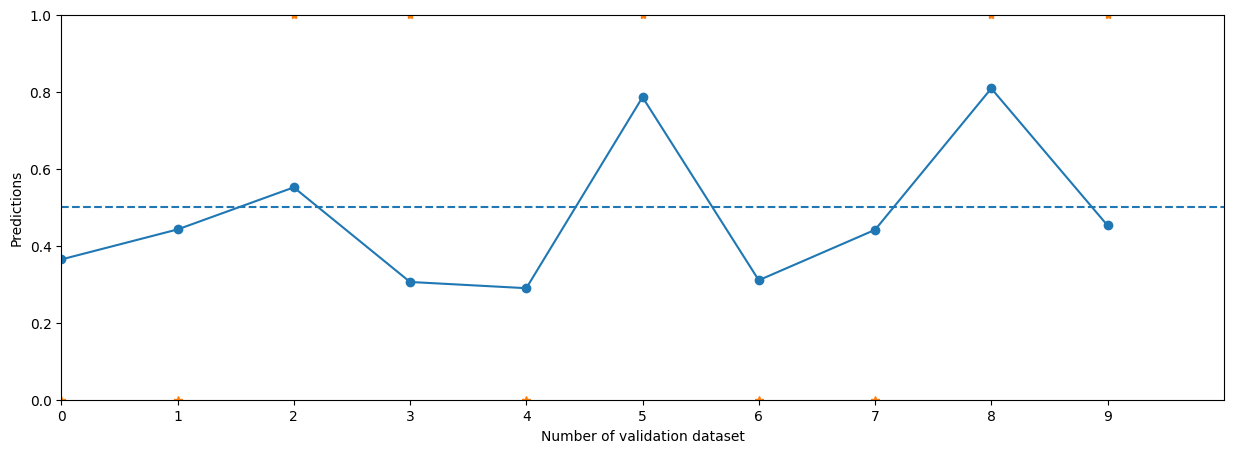

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
for i in range(0,1,1):

  plt.plot(y_pred2,'o-')
  plt.plot(y_val,'*')
  plt.axhline(y = 0.5, linestyle = '--')

  plt.xlim([0,10])
  plt.xticks(range(10))
  plt.ylim(0,1)
  plt.ylabel('Predictions')
  plt.xlabel('Number of validation dataset')
  training_legend= "training_{:01d}".format(i)
  #plt.legend(loc='upper left', title=training_legend, fontsize=10)
  #plt.legend['training dataset 0','training dataset 1','training dataset 2','training dataset 3']

In [23]:
y_pred2 = y_pred2.copy()
y_pred2[y_pred2<0.5] = 0
y_pred2[y_pred2>0.5] = 1

In [24]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_val, y_pred2)
print(cnf_matrix)
tn, fp, fn ,tp = confusion_matrix(y_val,y_pred2).reshape(-1)
print('Valeurs de TN, FP, FN, TP : \n',tn, fp, fn, tp)
from sklearn.metrics import classification_report
matrix = classification_report(y_val,y_pred2)
print('Rapport de Classification  : \n',matrix)


[[5 0]
 [2 3]]
Valeurs de TN, FP, FN, TP : 
 5 0 2 3
Rapport de Classification  : 
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



version3

High scans training indices: [210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 286, 287, 288, 289, 290, 291, 292, 293, 294]
Low scans training indices [120, 110, 165, 151, 51, 187, 182, 102, 130, 106, 66, 39, 171, 180, 1, 28, 112, 59, 47, 203, 136, 122, 12, 146, 67, 32, 209, 36, 204, 174, 139, 147, 156, 85, 117, 160, 133, 113, 144, 118, 42, 125, 119, 70, 184, 74, 137, 128, 65, 163, 116, 19, 77, 64, 73, 89, 175, 142, 20, 37, 40, 63, 202, 41, 56, 16, 208, 108, 88, 123, 206, 15, 54, 111, 103, 5, 101, 126, 0, 124, 191, 148, 100, 205, 197, 169, 138, 55, 72, 99, 98, 154, 200, 81, 29]
training indices: [103, 253, 139, 19, 230, 206, 171, 257, 119, 245, 1, 202, 163, 100, 148, 238, 293, 40, 281,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 1s 15ms/step - loss: 0.6953 - acc: 0.5143 - val_loss: 0.6844 - val_acc: 0.6000
Epoch 3/100
88/88 [==============================] - 1s 15ms/step - loss: 0.6894 - acc: 0.5600 - val_loss: 0.6805 - val_acc: 0.7000
Epoch 4/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6904 - acc: 0.5257 - val_loss: 0.6679 - val_acc: 0.7000
Epoch 5/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6881 - acc: 0.5429 - val_loss: 0.6625 - val_acc: 0.7000
Epoch 6/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6778 - acc: 0.5886 - val_loss: 0.6553 - val_acc: 0.7000
Epoch 7/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6839 - acc: 0.5943 - val_loss: 0.6484 - val_acc: 0.7000
Epoch 8/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6750 - acc: 0.6457 - val_loss: 0.6303 - val_acc: 0.7000
Epoch 9/100
88/88 [==============================] - 1s 13ms/step - loss: 0.6843 - acc: 

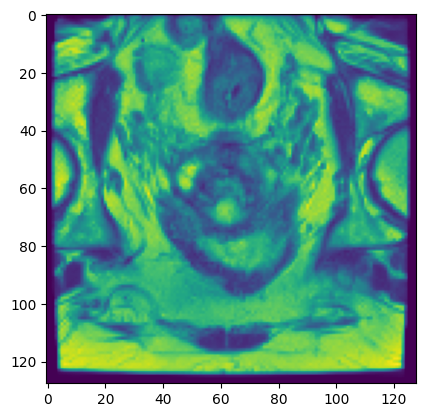

In [25]:
for i in range (0,1,1):
    #trainning_datase
    x_train = np.ndarray(shape=(175,16,128,128))
    y_train = np.ndarray(shape=(175,))
    High_scans_training_indices = remaining_indices[205:205+80]
    print('High scans training indices:',High_scans_training_indices)
    low_scans_training_indices = random.sample(range(205), 95)
    low_scans_training_indices = [remaining_indices[i] for i in low_scans_training_indices]
    print('Low scans training indices',low_scans_training_indices)
    training_selected_indices = High_scans_training_indices+low_scans_training_indices
    random.shuffle(training_selected_indices)
    print('training indices:',training_selected_indices)
    x_train = scans[training_selected_indices]
    y_train = labels[training_selected_indices]
    print('Trainning data shape:',x_train.shape)
    print('Traning data labels:',y_train)

    # Define data loaders.
    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    batch_size = 2
    # Augment the on the fly during training.
    train_dataset = (
          train_loader.shuffle(len(x_train))
          .map(train_preprocessing)
          .batch(batch_size)
          .prefetch(2))
    # Only rescale.
    validation_dataset = (
          validation_loader.shuffle(len(x_val))
          .map(validation_preprocessing)
          .batch(batch_size)
          .prefetch(2))
    #show image
    import matplotlib.pyplot as plt

    data = train_dataset.take(1)
    images, image_labels = list(data)[0]
    images = images.numpy()
    image = images[0]
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(np.squeeze(image[4, :, ])) #cmap="gray")

    # Visualize montage of slices.
    # 4 rows and 10 columns for 100 slices of the CT scan.
    #plot_slices(3, 5, 128, 128, image[:, :, :15])

    # model
    # Compile model.
    initial_learning_rate = 0.0001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
            )

    model3 = get_model(depth=16, height=128, width=128)
    model3.compile(
            loss="binary_crossentropy",
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=["acc"],
                  )
# Define callbacks.
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
            "wavelet_haar_3d_cnn_version3.h5", save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
    epochs = 100
    model3.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=epochs,
            batch_size = 32,
            shuffle=True,
            verbose=1,
            callbacks=[checkpoint_cb, early_stopping_cb])
            #model prediction
    preds3 = model3.predict(validation_dataset,verbose=1)
    predictions3 = preds3.copy()

prediction

In [26]:
from tensorflow.keras.models import load_model
model1 = load_model('wavelet_haar_3d_cnn_version1.h5')
y_pred1 = np.ndarray(shape=(10,))
model2 = load_model('wavelet_haar_3d_cnn_version2.h5')
y_pred2 = np.ndarray(shape=(10,))
model3 = load_model('wavelet_haar_3d_cnn_version3.h5')
y_pred3 = np.ndarray(shape=(10,))

In [27]:
for num in range(0,10,1):


  prediction1 = model1.predict(np.expand_dims(x_val[num], axis=0))[0]
  y_pred1[num] = prediction1
  prediction2 = model2.predict(np.expand_dims(x_val[num], axis=0))[0]
  y_pred2[num] = prediction2
  prediction3= model3.predict(np.expand_dims(x_val[num], axis=0))[0]
  y_pred3[num] = prediction3

1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 70ms/step


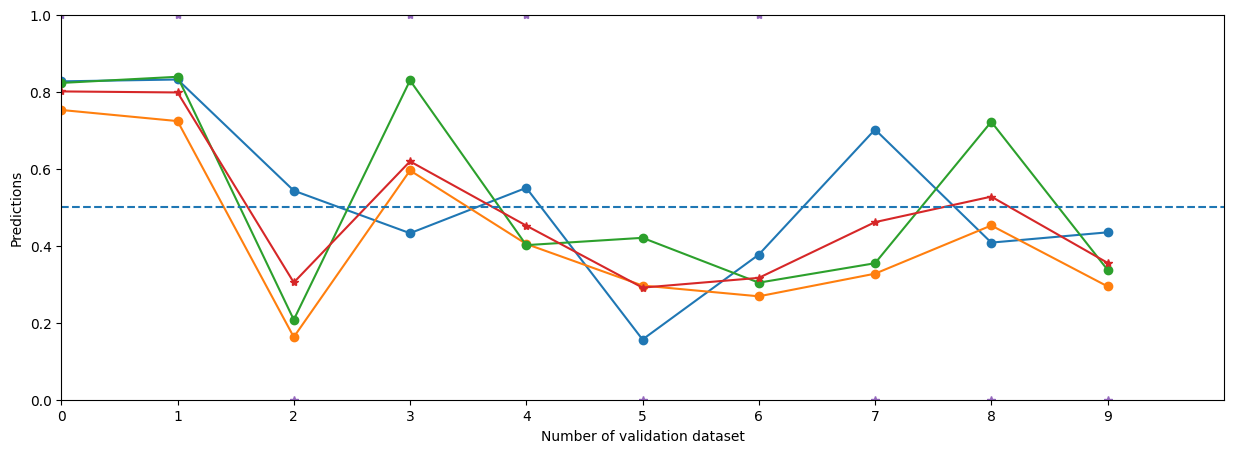

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
for i in range(0,1,1):

  plt.plot(y_pred1,'o-')
  plt.plot(y_pred2,'o-')
  plt.plot(y_pred3,'o-')
  plt.plot((y_pred1+y_pred2+y_pred3)/3,'*-')
  plt.plot(y_val,'*')
  plt.axhline(y = 0.5, linestyle = '--')

  plt.xlim([0,10])
  plt.xticks(range(10))
  plt.ylim(0,1)
  plt.ylabel('Predictions')
  plt.xlabel('Number of validation dataset')


In [29]:
print(np.mean(y_pred3))

0.5238888934254646


In [30]:
y_pred_mean = (y_pred1+y_pred2+y_pred3)/3


In [31]:
y_pred_mean_copy = y_pred_mean.copy()
y_pred_mean_copy[y_pred_mean_copy<0.5] = 0
y_pred_mean_copy[y_pred_mean_copy>0.5] = 1

In [32]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_val, y_pred_mean_copy)
print(cnf_matrix)
tn, fp, fn ,tp = confusion_matrix(y_val,y_pred_mean_copy).reshape(-1)
print('Valeurs de TN, FP, FN, TP : \n',tn, fp, fn, tp)
from sklearn.metrics import classification_report
matrix = classification_report(y_val,y_pred_mean_copy)
print('Rapport de Classification  : \n',matrix)

[[4 1]
 [2 3]]
Valeurs de TN, FP, FN, TP : 
 4 1 2 3
Rapport de Classification  : 
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



In [33]:
sen = tp/(tp+fn)
print('sen:', sen)
spe = tn/(tn+fp)
print('spe:', spe)
balence_acc = (sen+spe)/2
print('banlence_acc:',balence_acc)


sen: 0.6
spe: 0.8
banlence_acc: 0.7


Rcnn : ROC AUC=0.800
score: 0.7400000000000001


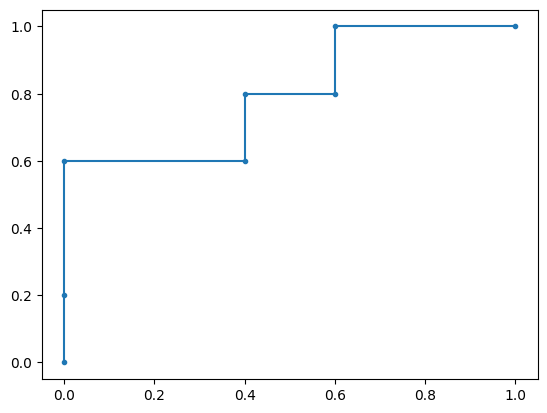

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
lr_auc = roc_auc_score(y_val, y_pred_mean)
lr_fpr, lr_tpr, _ = roc_curve(y_val, y_pred_mean)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='cnn')
print('Rcnn : ROC AUC=%.3f' % (lr_auc))
score = 0.4*lr_auc +0.2*sen +0.2*spe +0.2* balence_acc
print('score:', score)

test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!ls "/content/gdrive/My Drive/Model_cnn_prostate"

 37936b60-5d3d-4412-bc72-3576e33efad2.mha
 83fcbaa0-f9b6-423c-9876-63f355fa0bef.mha
 b66a10b4-623c-40d5-b59e-d7a569081fa6.mha
'Copie de easyensemble_imblance_classfication_3dimage.ipynb'
 easyensemble_imblance_classfication_3dimage.ipynb
 final_stk_cnn_wavelet_classfication_3dimage.ipynb
 stk_cnn_wavelet_classfication_3dimage.ipynb
 stk_imblance_classfication_3dimage.ipynb


In [36]:
from pathlib import Path
import glob

In [37]:

image_input_dir = "/content/gdrive/My Drive/Model_cnn_prostate"
image_input_path = list(Path(image_input_dir).glob("*.mha"))

In [38]:
print(image_input_path)

[PosixPath('/content/gdrive/My Drive/Model_cnn_prostate/37936b60-5d3d-4412-bc72-3576e33efad2.mha'), PosixPath('/content/gdrive/My Drive/Model_cnn_prostate/83fcbaa0-f9b6-423c-9876-63f355fa0bef.mha'), PosixPath('/content/gdrive/My Drive/Model_cnn_prostate/b66a10b4-623c-40d5-b59e-d7a569081fa6.mha')]


In [47]:
image = process_scan(image_input_path[2])

In [48]:
image.shape

(16, 128, 128)

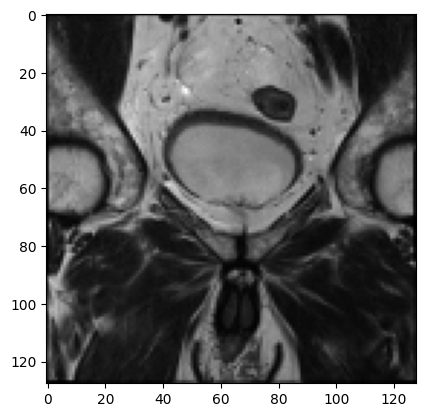

In [49]:
plt.imshow(image[1,:,:],cmap = 'gray')

In [50]:
  pred1 = model1.predict(np.expand_dims(image, axis=0))[0]
  print(pred1)
  pred2 = model2.predict(np.expand_dims(image, axis=0))[0]
  print(pred2)
  pred3= model3.predict(np.expand_dims(image, axis=0))[0]
  print(pred3)
  print((pred1+pred2+pred3)/3)

1/1 [==============================] - 0s 25ms/step
[0.45565328]
1/1 [==============================] - 0s 25ms/step
[0.40343788]
1/1 [==============================] - 0s 31ms/step
[0.41747403]
[0.42552173]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
(pred1+pred2+pred3)/3